In [1]:
import os
import csv

import random
import numpy as np

from sklearn.manifold.t_sne import TSNE
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import PCA, TruncatedSVD
from collections import OrderedDict

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
##Modify folder names
disease_folder = 'autism'
date_time_folder = '2018-11-20-17-20-33'
experiment_folder = 'autism2018-11-26-14-13-58'
data_folder = os.path.expanduser('~/data1/complex_disorders/data/%s/cohorts/%s' % (disease_folder, date_time_folder))

##Read encoded vectors file and ordered medical record numbers
with open(os.path.expanduser('~/data1/complex_disorders/experiments/%s' % experiment_folder) + '/encoded_vect.csv') as f:
    rd = csv.reader(f)
    encoded_vect = []
    for r in rd:
        encoded_vect.append(list(map(float, r)))
        
with open(os.path.expanduser('~/data1/complex_disorders/experiments/%s' % experiment_folder) + '/mrns.csv') as f:
    rd = csv.reader(f)
    mrns = []
    for r in rd:
        mrns.append(r[0])

with open(data_folder + '/cohort-new_ehr.csv') as f:
    rd = csv.reader(f)
    raw_ehr = {}
    for r in rd:
        raw_ehr.setdefault(r[0], list()).extend(list(map(int, r[1::])))

##padded raw data
raw_data = []
max_len = 0
for _, e in raw_ehr.items():
    raw_data.append(e)
    if len(e) >= max_len:
        max_len = len(e)
for idx, s in enumerate(raw_data):
    raw_data[idx] = s + [0]*(max_len-len(s))
    
##get list of first diagnosed diseases associated with mrns
with open(data_folder + '/cohort-mrn_diseases.csv') as f:
    rd = csv.reader(f)
    mrn_disease = {}
    for r in rd:
        mrn_disease[r[0]] = r[1::]
        
mrn_encoded_disease = []
for m in mrns:
    mrn_encoded_disease.append(mrn_disease[m][0])

disease_dict = {}
idx = 0
for d in set(mrn_encoded_disease):
    disease_dict[d] = idx
    idx += 1

mrn_raw_disease = []
for m in raw_ehr:
    mrn_raw_disease.append(mrn_disease[m][0])

with open( data_folder + '/cohort-new_vocab.csv') as f:
    rd = csv.reader(f)
    next(rd)
    new_vocab = {}
    for r in rd:
        new_vocab[r[1]] = r[0]
        
len_vocab = len(new_vocab)

In [3]:
def svd_tfidf(data, len_vocab):
    
    count_mat = np.zeros((len(data), len_vocab))
    
    for idx, token_list in enumerate(data):
        for t in token_list:
            if t != 0: ##we start the vocabulary from 1
                count_mat[idx, t-1] += 1
                
    tfidf = TfidfTransformer()
    tfidf_mat = tfidf.fit_transform(count_mat)
    
    svd = TruncatedSVD(n_components=32)
    svd_mat = svd.fit_transform(tfidf_mat)
    
    return svd_mat

##Hierarchical clustering function
def hclust_ehr(data, min_cl, max_cl, metric):
    best_silh = 0.0
    for n in range(min_cl,max_cl,1):
        hclust = AgglomerativeClustering(n_clusters=n, 
                                         linkage='complete', 
                                         affinity=metric)
        tmp_label = hclust.fit_predict(data).tolist()
        tmp_silh = silhouette_score(data, tmp_label)
        if tmp_silh > best_silh:
            best_silh = tmp_silh
            n_clust = n
            label = tmp_label
    print("Number of clusters found:{0}, Silhouette score:{1:.3f}".format(n_clust, best_silh))
    return n_clust, label

def svd_tfidf(data, len_vocab):
    
    count_mat = np.zeros((len(data), len_vocab))
    
    for idx, token_list in enumerate(data):
        for t in token_list:
            if t != 0: ##we start the vocabulary from 1
                count_mat[idx, t-1] += 1
                
    tfidf = TfidfTransformer()
    tfidf_mat = tfidf.fit_transform(count_mat)
    
    svd = TruncatedSVD(n_components=32)
    svd_mat = svd.fit_transform(tfidf_mat)
    
    return svd_mat

def FreqDict(tokens):
    freq_dict = {}
    for seq in tokens:
        for s in seq:
            if s not in freq_dict:
                freq_dict[s] = 1
            else:
                freq_dict[s] += 1
    return freq_dict

def freq_term(data, n_clusters, pred_class, n, term_list):
    encoded_groups = OrderedDict()
    encoded_seq = OrderedDict()
    for i in range(n_clusters):
        encoded_groups[i] = []
        encoded_seq[i] = []
        for j in range(len(pred_class)):
            if pred_class[j] == i:
                encoded_groups[i] += [mrns[j]]
                encoded_seq[i].append([rd for rd in data[j] if rd!=0 and (str.split(new_vocab[str(rd)], "::")[0] in term_list)])
                
    for cl in range(n_clusters):
        encoded_count = FreqDict(encoded_seq[cl])
        for l in range(n):
            MFMT = max(encoded_count, key=(lambda key: encoded_count[key]))
            num_MFMT = 0
            for el in data:
                for t in el:
                    if t == MFMT:
                        num_MFMT += 1
    
            print("Cluster {0} -- Relative numerosity of first most frequent term:{1} = {2:.2f}".format(cl,new_vocab[str(MFMT)], 
                                                                                                encoded_count[MFMT]/num_MFMT))
            encoded_count.pop(MFMT)
        print("\n")

In [4]:
##initialize T-SNE
tsne = TSNE(n_components=2, n_iter=5000, perplexity=50, random_state=42)
colormap = np.arange(0, 1, 0.01).tolist()

## Clustering CNN+AE encoded vectors

In [5]:
##run the TSNE on data
encoded_tsne = tsne.fit_transform(encoded_vect)

In [6]:
colors_en1 = [colormap[disease_dict[v]] for v in mrn_encoded_disease]

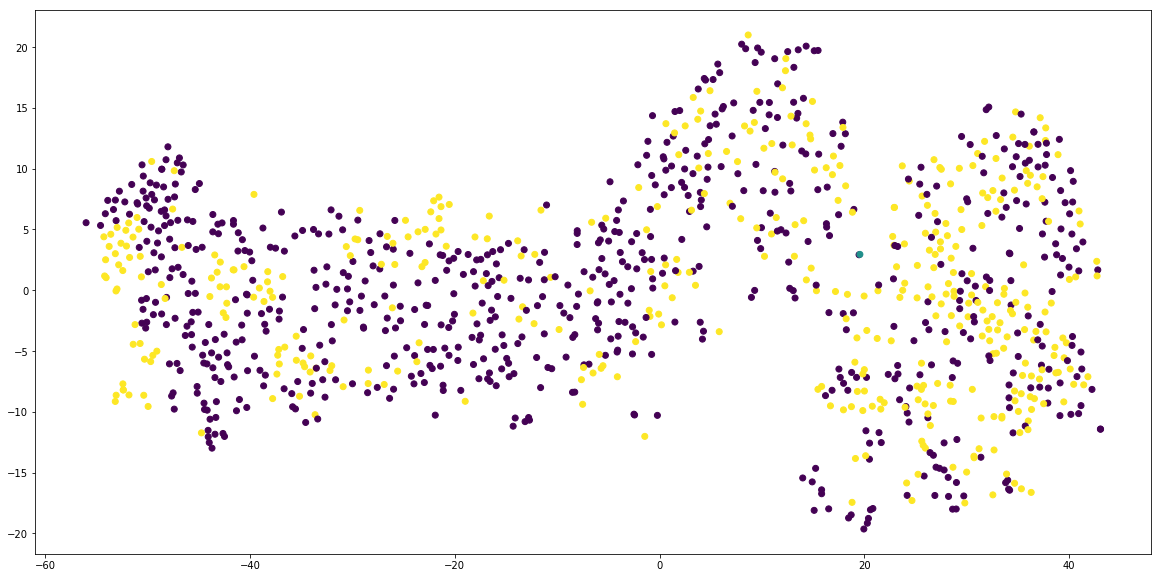

In [7]:
plt.figure(figsize=(20,10))
plt.scatter(encoded_tsne[:,0], encoded_tsne[:,1], c=colors_en1)

In [8]:
##Apply hierarchical clustering to data
n_clust_en, label_en = hclust_ehr(encoded_vect, 4, 40, 'l1')

Number of clusters found:13, Silhouette score:0.153


In [9]:
colors_en2 = [colormap[v] for v in label_en]

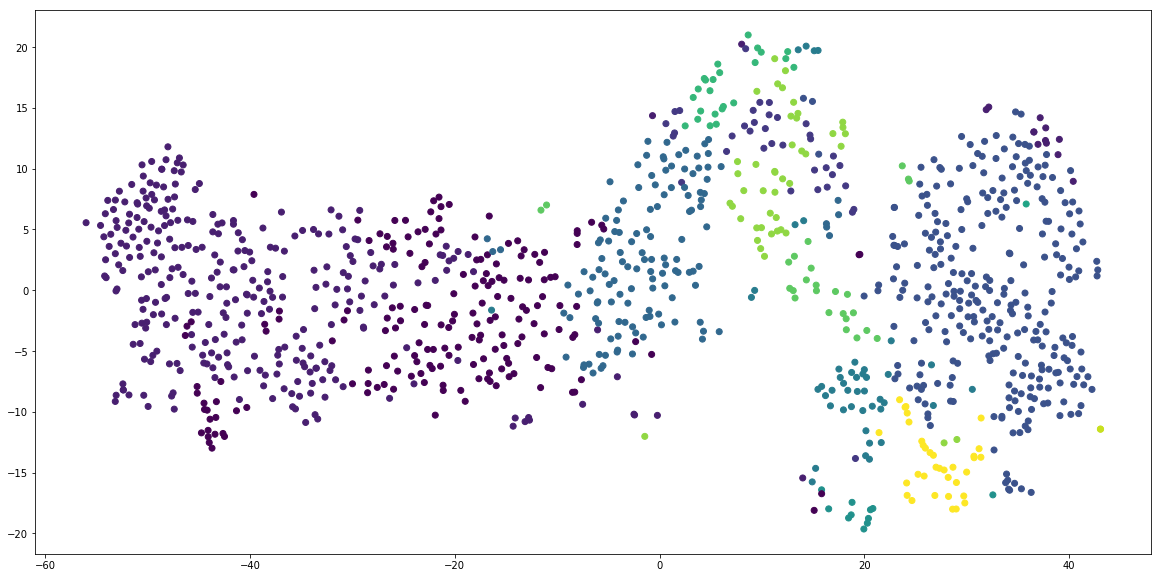

In [10]:
plt.figure(figsize=(20,10))
plt.scatter(encoded_tsne[:,0], encoded_tsne[:,1], c=colors_en2)

In [11]:
freq_term(raw_data, n_clust_en, label_en, 4, ['icd9', 'medication'])

Cluster 0 -- Relative numerosity of first most frequent term:icd9::Autistic disorder, current or active state::299.00::C0154446 = 0.16
Cluster 0 -- Relative numerosity of first most frequent term:icd9::Routine infant or child health check::V20.2::C0260545 = 0.17
Cluster 0 -- Relative numerosity of first most frequent term:icd9::Unspecified pervasive developmental disorder, current or active state::299.90::C0154453 = 0.17
Cluster 0 -- Relative numerosity of first most frequent term:icd9::Need for prophylactic vaccination and inoculation against influenza::V04.81::C1260452 = 0.16


Cluster 1 -- Relative numerosity of first most frequent term:icd9::Autistic disorder, current or active state::299.00::C0154446 = 0.29
Cluster 1 -- Relative numerosity of first most frequent term:icd9::Routine infant or child health check::V20.2::C0260545 = 0.27
Cluster 1 -- Relative numerosity of first most frequent term:icd9::Attention deficit disorder with hyperactivity::314.01::C1263846 = 0.39
Cluster 1 --

## Raw data

In [12]:
scaler = StandardScaler()
raw_data_scaled = scaler.fit_transform(raw_data)

In [13]:
# ##T-SNE
raw_tsne = tsne.fit_transform(raw_data_scaled)

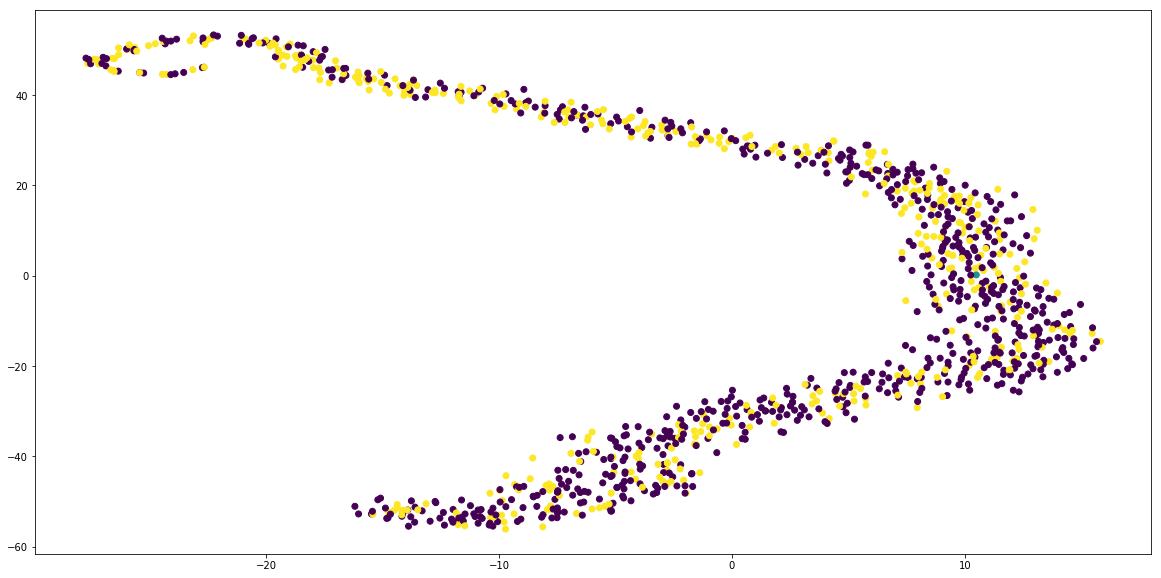

In [14]:
colors_raw1 = [colormap[disease_dict[v]] for v in mrn_raw_disease]
plt.figure(figsize=(20,10))
plt.scatter(raw_tsne[:,0], raw_tsne[:,1], c=colors_raw1)

In [15]:
n_clust_raw, label_raw = hclust_ehr(raw_data_scaled, 4, 40, 'cosine')

Number of clusters found:6, Silhouette score:0.264


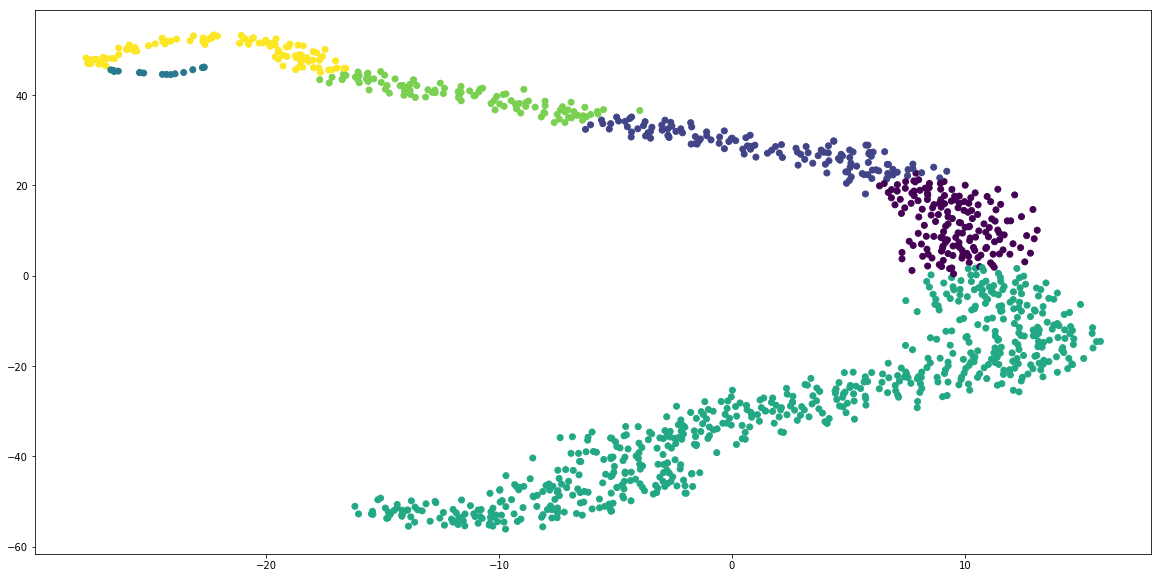

In [16]:
colors_raw2 = [colormap[v] for v in label_raw]
plt.figure(figsize=(20,10))
plt.scatter(raw_tsne[:,0], raw_tsne[:,1], c=colors_raw2)

In [17]:
freq_term(raw_data, n_clust_raw, label_raw, 4, ['icd9', 'medication'])

Cluster 0 -- Relative numerosity of first most frequent term:icd9::Autistic disorder, current or active state::299.00::C0154446 = 0.14
Cluster 0 -- Relative numerosity of first most frequent term:icd9::Routine infant or child health check::V20.2::C0260545 = 0.13
Cluster 0 -- Relative numerosity of first most frequent term:icd9::Unspecified pervasive developmental disorder, current or active state::299.90::C0154453 = 0.12
Cluster 0 -- Relative numerosity of first most frequent term:icd9::Attention deficit disorder with hyperactivity::314.01::C1263846 = 0.12


Cluster 1 -- Relative numerosity of first most frequent term:icd9::Routine infant or child health check::V20.2::C0260545 = 0.27
Cluster 1 -- Relative numerosity of first most frequent term:icd9::Autistic disorder, current or active state::299.00::C0154446 = 0.14
Cluster 1 -- Relative numerosity of first most frequent term:icd9::Need for prophylactic vaccination and inoculation against influenza::V04.81::C1260452 = 0.24
Cluster 1 --

## Count data

In [18]:
svd_mat = svd_tfidf(raw_data, len_vocab)

In [19]:
# ##T-SNE
count_tsne = tsne.fit_transform(svd_mat)

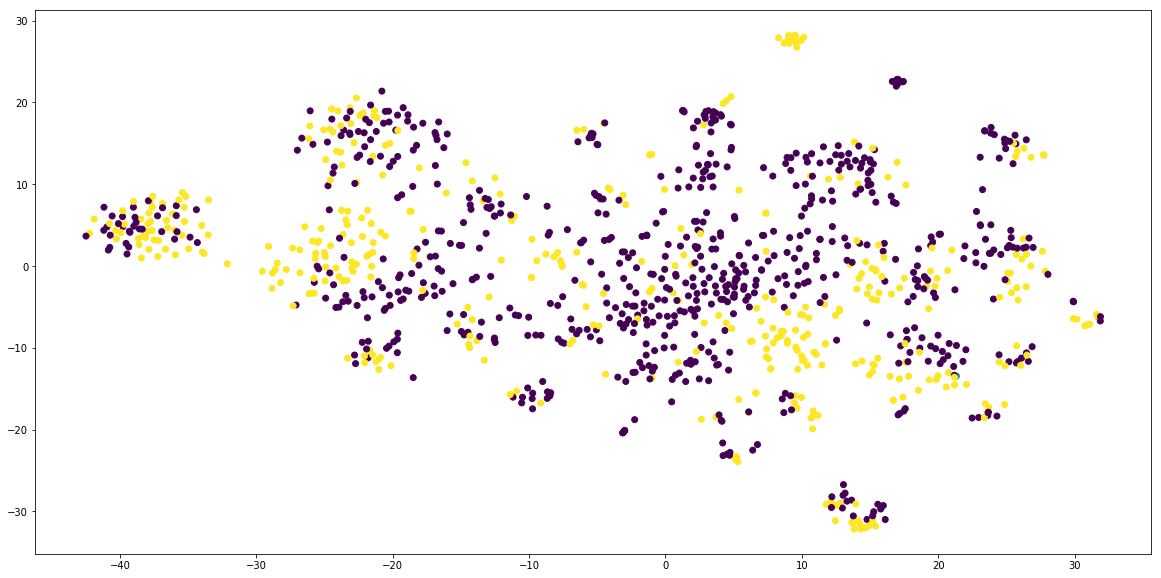

In [20]:
colors_count1 = [colormap[disease_dict[v]] for v in mrn_raw_disease]
plt.figure(figsize=(20,10))
plt.scatter(count_tsne[:,0], count_tsne[:,1], c=colors_count1)

In [21]:
n_clust_count, label_count = hclust_ehr(svd_mat, 4, 40, 'cosine')

Number of clusters found:34, Silhouette score:0.086


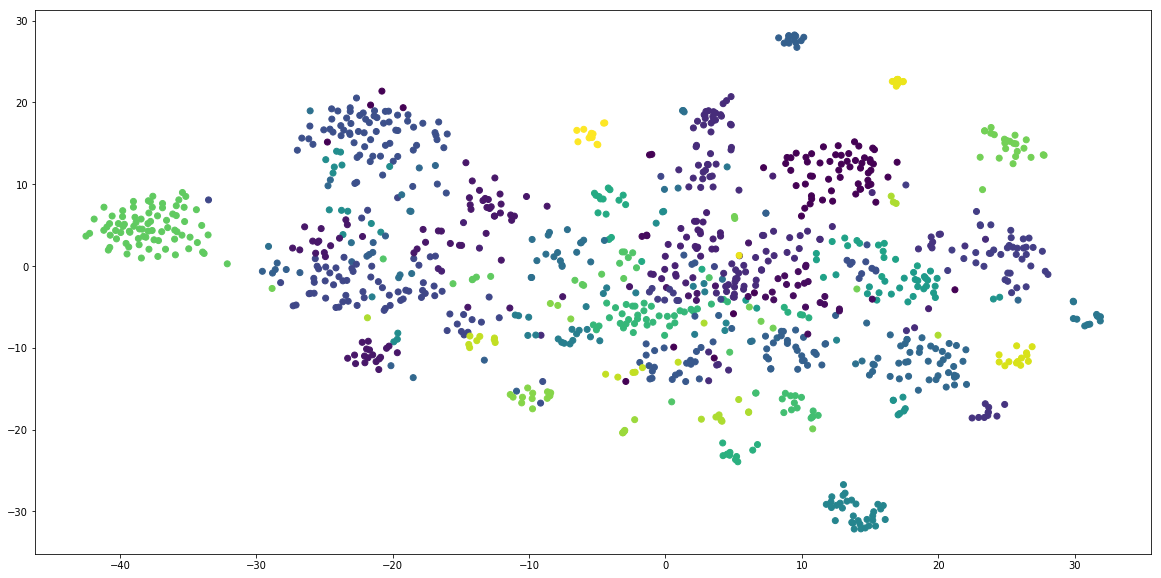

In [22]:
colors_count2 = [colormap[v] for v in label_count]
plt.figure(figsize=(20,10))
plt.scatter(count_tsne[:,0], count_tsne[:,1], c=colors_count2)

In [23]:
freq_term(raw_data, n_clust_count, label_count, 4, ['icd9', 'medication'])

Cluster 0 -- Relative numerosity of first most frequent term:icd9::Epilepsy, unspecified, without mention of intractable epilepsy::345.90::C0154721 = 0.58
Cluster 0 -- Relative numerosity of first most frequent term:icd9::Autistic disorder, current or active state::299.00::C0154446 = 0.09
Cluster 0 -- Relative numerosity of first most frequent term:icd9::Other convulsions::780.39::C0490011 = 0.46
Cluster 0 -- Relative numerosity of first most frequent term:icd9::Routine infant or child health check::V20.2::C0260545 = 0.03


Cluster 1 -- Relative numerosity of first most frequent term:icd9::Unspecified psychosis::298.9::C0033975 = 0.24
Cluster 1 -- Relative numerosity of first most frequent term:icd9::Autistic disorder, current or active state::299.00::C0154446 = 0.02
Cluster 1 -- Relative numerosity of first most frequent term:medication::Clonazepam 0.5 mg::315699::C0985016 = 0.56
Cluster 1 -- Relative numerosity of first most frequent term:icd9::Depressive disorder, not elsewhere clas